In [2]:
import numpy as np
import pandas as pd
from tqdm import tqdm
from scipy.stats import rayleigh

import matplotlib
import matplotlib.pyplot as plt
from matplotlib import animation
from matplotlib.animation import FuncAnimation

import sys

In [3]:
sys.path.append("/home/michael/SBDPP_sim") # your path to the SBDPP_sim folder
import simulation

In [4]:
L = 50                # Area side length
M = 2                 # Number of species


r_values = np.arange(0, 5.01, 0.01)
q_values = np.arange(0, 1.0, 0.001)


# Radial density function for 2D spatial interaction kernel
# Uses normalized Gaussian distribution in polar coordinates for circular symmetry
def radial_density_2d(r, sigma):
    return (1.0 / (2 * np.pi * sigma**2)) * np.exp(-0.5 * (r/sigma)**2)


g2 = simulation.PyGrid2(
    M = M,
    areaLen = [L, L],                  # Domain size in x, y
    cellCount = [L, L],                # Number of cells in x, y
    isPeriodic = True,                 # Periodic boundary conditions
    birthRates = [0.4, 0.4],           # Baseline birth rates for each species
    deathRates = [0.2, 0.2],           # Baseline death rates for each species
    ddMatrix = [0.001, 0.001,          # Flattened MxM competition matrix
                0.001, 0.001],
    birthX = [q_values.tolist()] * M,  # Quantiles for birth kernel
    birthY=[                           # Radial density for birth kernel
        rayleigh.ppf(q_values, scale = 0.04).tolist(),
        rayleigh.ppf(q_values, scale = 0.04).tolist()
    ],
    deathX_ = [[r_values.tolist()] * M] * M,                           # Distance grid for interaction kernel (0 to 5.01)
    deathY_ = [[radial_density_2d(r_values, 0.04).tolist()] * M] * M,  # Interaction strength at each distance
    cutoffs = [5.0] * M * M,           # Interaction cutoff distances (flattened MxM)
    seed = 42,                         # Random number generator seed
    rtimeLimit = 3600.0                # Real-time limit in seconds
)

N = 1000  # Number of [x, y] pairs per group
coordinates = []
for _ in range(M):
    group = [[np.random.uniform(0, L), np.random.uniform(0, L)] for _ in range(N)]
    coordinates.append(group)

g2.placePopulation(coordinates)

print("Birth rate:", g2.total_birth_rate)
print("Death rate:", g2.total_death_rate)

Birth rate: 799.9999999999717
Death rate: 402.3690967321528


In [5]:
df = pd.DataFrame()

for t in (pbar := tqdm(range(150))):
    arrays = [np.column_stack((sublist, np.full((len(sublist), 1), i))) for i, sublist in enumerate(g2.get_all_particle_coords())]
    final_array = np.vstack(arrays)
    df_t = pd.DataFrame(final_array, columns=['x', 'y', 's'])
    df_t['time'] = t
    df = pd.concat([df,df_t], ignore_index = True, sort = False)
    g2.run_for(1)
    pbar.set_description(f"Population: {final_array.shape[0]}, Progress")

  0%|          | 0/150 [00:00<?, ?it/s]

Population: 107698, Progress: 100%|██████████| 150/150 [13:52<00:00,  5.55s/it]


In [6]:
movie_writer = animation.FFMpegWriter(
    fps = 2,
    codec = 'h264',
    extra_args = ['-vcodec', 'libx264']
)

In [7]:
matplotlib.rcParams['animation.ffmpeg_path'] = '/usr/bin/ffmpeg' # Set the path to ffmpeg

df = df.sort_values('time')
output_file = "competition_colonization_2d.mp4"

fig, ax = plt.subplots(figsize=(8, 8))

ax.set_xlim(0, L)
ax.set_ylim(0, L)
ax.set_xlabel('x')
ax.set_ylabel('y')
sc = ax.scatter([], [], c = [], cmap = 'Set2', s = 20, alpha = 0.6)

def update(frame):
    current_df = df[df['time'] == frame]
    sc.set_offsets(current_df[['x', 'y']].values)
    sc.set_array(current_df['s'].values)
    ax.set_title(f"Time: {frame}")
    return sc,

ani = FuncAnimation(fig, update, frames=df['time'].nunique(), blit = True)

ani.save(output_file, writer = movie_writer)
print(f"Animation saved as {output_file}")
plt.close(fig)

Animation saved as competition_colonization_2d.mp4


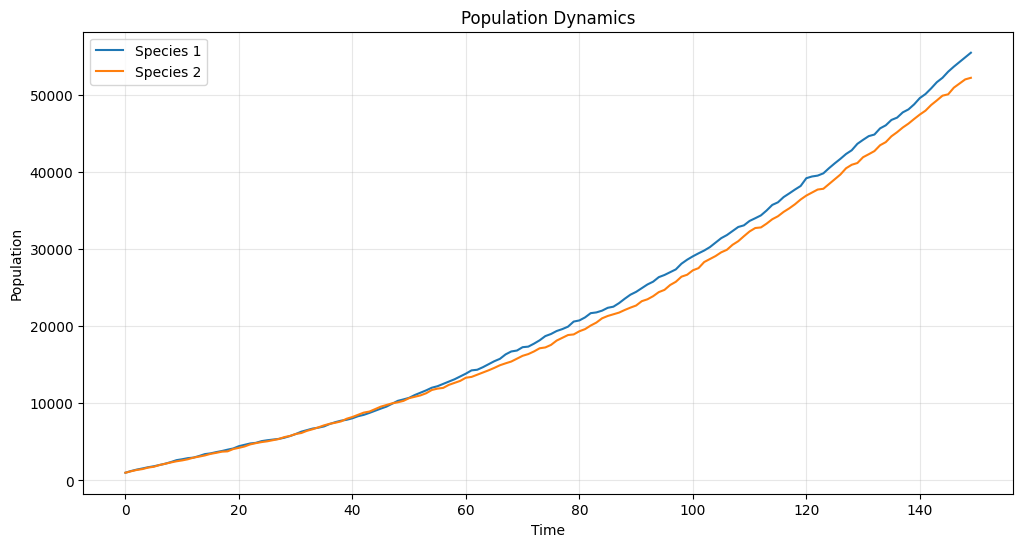

In [8]:
population_data = []
for t in df['time'].unique():
    current_df = df[df['time'] == t]
    for s in range(M):
        pop = len(current_df[current_df['s'] == s])
        population_data.append({'time': t, 'species': s, 'population': pop})

population_data = pd.DataFrame(population_data)



plt.figure(figsize = (12, 6))

for s in range(M):
    species_data = population_data[population_data['species'] == s]
    plt.plot(species_data['time'], species_data['population'], 
             label=f'Species {s + 1}')

plt.xlabel('Time')
plt.ylabel('Population')
plt.title('Population Dynamics')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()